In [1]:
import torch
# from transformers import MT5ForConditionalGeneration, AutoTokenizer
from transformers import T5Tokenizer, T5ForConditionalGeneration

In [2]:
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [4]:
# Load the fine-tuned T5 model
fine_tuned_model_path = "/soe/npullabh/244_final_project/t5/t5_fine_tuned.pt"
fine_tuned_tokenizer = "/soe/npullabh/244_final_project/t5/t5_tokenizer"
model = T5ForConditionalGeneration.from_pretrained(fine_tuned_model_path)
tokenizer = T5Tokenizer.from_pretrained(fine_tuned_tokenizer)

In [5]:
# tokenizer = T5Tokenizer.from_pretrained(fine_tuned_tokenizer)
tokenizer_french = T5Tokenizer.from_pretrained(fine_tuned_tokenizer, source_lang="fr")
tokenizer_eng = T5Tokenizer.from_pretrained(fine_tuned_tokenizer, source_lang="en")

In [6]:
# setup device based on availability
device = "cuda:3" if torch.cuda.is_available() else "cpu"
print("Using device: {}".format(device))

Using device: cuda:3


In [7]:
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [8]:
def generate_translation(source_text, words, target_prefix="", max_length=50, num_suggestions=1):
    # Tokenize the source sentence and add special tokens
    input_ids = tokenizer_french.encode(source_text, return_tensors='pt')
    target_ids = tokenizer_eng.encode(target_prefix, return_tensors='pt')

    input_ids = torch.cat((input_ids, target_ids), dim=-1).to(device)

    # Generate translation suggestions using the fine-tuned T5 model
    # Experiment 1: beam search
    output = model.generate(
        input_ids=input_ids,
        num_beams=5, 
        max_length=max_length,
        no_repeat_ngram_size=2,
        early_stopping=True,
        num_return_sequences=num_suggestions
    )

    # Decode the generated sequences and remove special tokens
    suggestions = []
    word_suggestions = []
    for i in range(output.shape[0]):
        suggestion = tokenizer.decode(output[i], skip_special_tokens=True)
        suggestion = suggestion[len(target_prefix):].strip()
        suggestions.append(suggestion)

    return suggestions

## Experiments

In [10]:
dev_source_text_path = "../data/sup_valid.en-fr.fr"
dev_target_text_path = "../data/sup_valid.en-fr.en"

In [11]:
test_source_text_path = "../data/test.en-fr.fr"
test_target_text_path = "../data/test.en-fr.en"

In [12]:
# read the data from the files and store them in pandas dataframe
def retrieve_data(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f.readlines():
            line = line.strip()
            data.append(line)
    return data

In [13]:
dev_source_sentences = retrieve_data(dev_source_text_path)
dev_target_sentences = retrieve_data(dev_target_text_path)

In [14]:
test_source_sentences = retrieve_data(test_source_text_path)
test_target_sentences = retrieve_data(test_target_text_path)

In [15]:
def truncate_sentences(percent, data):
    partial_prefixes = []
    for sentence in data:
        sentence_tokens = sentence.split()
        sent_len = round(len(sentence_tokens) * percent)
        partial_prefix = ' '.join(sentence_tokens[:sent_len])
        partial_prefixes.append(partial_prefix)
    return partial_prefixes

In [16]:
def prefix_partial_completion(percent, source_sentences, target_sentences):
    partial_prefixes = truncate_sentences(percent, target_sentences)
    predictions = []
    for index, prefix in tqdm(enumerate(partial_prefixes), total=len(partial_prefixes)):
        source_text = source_sentences[index]
        suggestion = generate_translation(source_text, 0, prefix)
        pred = prefix + " " + suggestion[0]
        predictions.append(pred)
    return predictions

In [17]:
def find_blue_score_for_x_percent_translations(x_percent, preds, target_sentences):
    references = [[target_sent.split()] for target_sent in target_sentences]
    percent_candidates = [pred_sent.split() for pred_sent in preds]
    bleu_percent = corpus_bleu(references, percent_candidates)
    print(f'BLEU score with {x_percent * 100}% partial translation: ', bleu_percent)
    return bleu_percent

#### Experiment 1: beam search

In [18]:
# dev set
def evaluate_on_dev_set():
    percents = [0.0, 0.10, 0.20, 0.40]
    all_bleu_scores_dev = []
    for percent in percents:
        predictions = prefix_partial_completion(percent, dev_source_sentences, 
                                                dev_target_sentences)
        bleu_score = find_blue_score_for_x_percent_translations(percent, predictions, 
                                                                dev_target_sentences)
        all_bleu_scores_dev.append(bleu_score)
    return all_bleu_scores_dev

In [ ]:
# beam search
all_bleu_scores_dev = evaluate_on_dev_set()

In [19]:
# test set
def evaluate_on_test_set():
    percents = [0.0, 0.10, 0.20, 0.40]
    all_bleu_scores_test = []
    all_predictions = []
    for percent in percents:
        predictions = prefix_partial_completion(percent, test_source_sentences, 
                                                test_target_sentences)
        bleu_score = find_blue_score_for_x_percent_translations(percent, predictions, 
                                                                test_target_sentences)
        all_bleu_scores_test.append(bleu_score)
        all_predictions.extend(predictions)
    return all_predictions, all_bleu_scores_test

In [31]:
# beam search 
all_bleu_scores_test = evaluate_on_test_set()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2007/2007 [08:27<00:00,  3.96it/s]


BLEU score with 0.0% partial translation:  0.18423978163291235


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2007/2007 [08:10<00:00,  4.09it/s]


BLEU score with 10.0% partial translation:  0.2145359756107007


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2007/2007 [08:23<00:00,  3.99it/s]


BLEU score with 20.0% partial translation:  0.29484160454830594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2007/2007 [08:21<00:00,  4.00it/s]

BLEU score with 40.0% partial translation:  0.46162058719410043


In [34]:
beam_search_test_scores = all_bleu_scores_test

In [28]:
beam_search_test_scores = [0.18423978163291235, 0.2145359756107007,
                          0.29484160454830594, 0.46162058719410043]

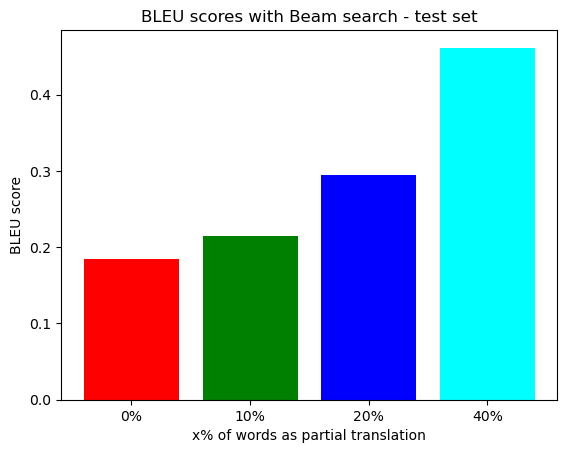

In [29]:
# create a dataset
bars = ('0%', '10%', '20%', '40%')
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.bar(x_pos, beam_search_test_scores, color=['red', 'green', 'blue', 'cyan'])

# Create names on the x-axis
plt.xticks(x_pos, bars)

plt.xlabel('x% of words as partial translation')
plt.ylabel('BLEU score')
plt.title("BLEU scores with Beam search - test set")

# Show graph
plt.show()

#### Experiment 2 - random sampling

In [20]:
def generate_translation(source_text, words, target_prefix="", max_length=50, num_suggestions=1):
    # Tokenize the source sentence and add special tokens
    input_ids = tokenizer_french.encode(source_text, return_tensors='pt')
    target_ids = tokenizer_eng.encode(target_prefix, return_tensors='pt')

    input_ids = torch.cat((input_ids, target_ids), dim=-1).to(device)

    # Experiment 2: 
    # Random sampling
    output = model.generate(
        input_ids, 
        do_sample=True, 
        max_length=50, 
        top_k=0,
        num_return_sequences=num_suggestions
    )
    
    # Decode the generated sequences and remove special tokens
    suggestions = []
    word_suggestions = []
    for i in range(output.shape[0]):
        suggestion = tokenizer.decode(output[i], skip_special_tokens=True)
#         print(suggestion.split())
        suggestion = suggestion[len(target_prefix):].strip()
        suggestions.append(suggestion)
    return suggestions

In [16]:
# debug
source_text = "merci beaucoup pour cet éclaircissement , monsieur le commissaire"
target_prefix = "than"
generate_translation(source_text, 0, target_prefix)

['a great deal of light, commissioner.']

In [15]:
percent = [0.0, 0.1, 0.2, 0.4]
def run_eval(percent):
    scores = []
    for val in percent:
        preds = prefix_partial_completion(val)
        dev_score = find_blue_score_for_x_percent_translations(val, preds)
        scores.append(dev_score)
    return scores

In [2]:
def round_scores(bleu_scores):
    bleu_scores_rounded = []
    for score in bleu_scores:
        score = round(score * 100)
        bleu_scores_rounded.append(score)
    return bleu_scores_rounded

In [28]:
random_sampling_scores = run_eval(percent)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [07:51<00:00,  4.24it/s]


Dev BLEU score with 0.0 partial translation:  0.09487372037855815


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [07:09<00:00,  4.66it/s]


Dev BLEU score with 10.0 partial translation:  0.10737419352938729


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [06:25<00:00,  5.19it/s]


Dev BLEU score with 20.0 partial translation:  0.18728035455535916


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [07:26<00:00,  4.48it/s]


Dev BLEU score with 40.0 partial translation:  0.3743397749400694


In [33]:
bleu_scores = [0.09487372037855815, 0.10737419352938729, 0.18728035455535916, 0.3743397749400694]
random_sampling_scores = round_scores(bleu_scores)

In [34]:
random_sampling_scores

[9, 11, 19, 37]

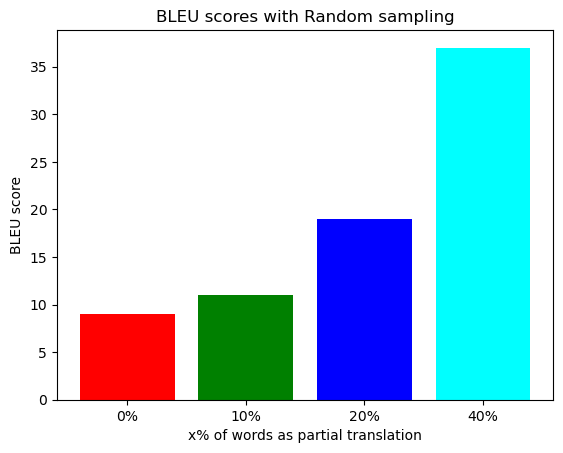

In [37]:
# create a dataset
bars = ('0%', '10%', '20%', '40%')
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.bar(x_pos, random_sampling_scores, color=['red', 'green', 'blue', 'cyan'])

# Create names on the x-axis
plt.xticks(x_pos, bars)

plt.xlabel('x% of words as partial translation')
plt.ylabel('BLEU score')
plt.title("BLEU scores with Random sampling")

# Show graph
plt.show()

In [22]:
predictions, all_bleu_scores_test = evaluate_on_test_set()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2007/2007 [06:31<00:00,  5.12it/s]


BLEU score with 0.0% partial translation:  0.07578658371407802


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2007/2007 [06:31<00:00,  5.13it/s]


BLEU score with 10.0% partial translation:  0.11363045773202687


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2007/2007 [06:29<00:00,  5.15it/s]


BLEU score with 20.0% partial translation:  0.20813338564259026


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2007/2007 [06:35<00:00,  5.08it/s]

BLEU score with 40.0% partial translation:  0.40722807539633105


In [23]:
random_sampling_scores_test = all_bleu_scores_test

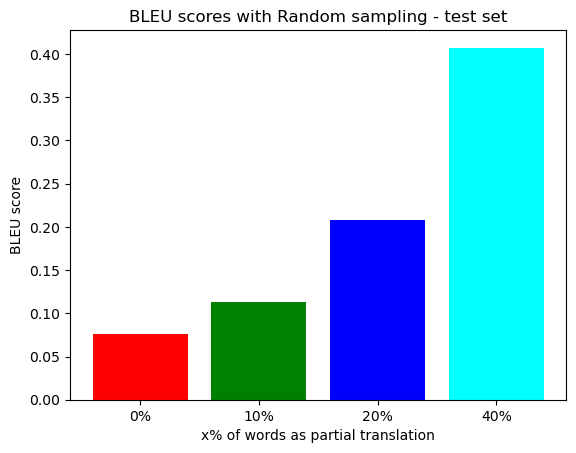

In [26]:
# create a dataset
bars = ('0%', '10%', '20%', '40%')
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.bar(x_pos, random_sampling_scores_test, color=['red', 'green', 'blue', 'cyan'])

# Create names on the x-axis
plt.xticks(x_pos, bars)

plt.xlabel('x% of words as partial translation')
plt.ylabel('BLEU score')
plt.title("BLEU scores with Random sampling - test set")

# Show graph
plt.show()

#### Experiment 3: Top-k sampling

In [30]:
def generate_translation(source_text, words, target_prefix="", max_length=50, num_suggestions=1):
    # Tokenize the source sentence and add special tokens
    input_ids = tokenizer_french.encode(source_text, return_tensors='pt')
    target_ids = tokenizer_eng.encode(target_prefix, return_tensors='pt')

    input_ids = torch.cat((input_ids, target_ids), dim=-1).to(device)

    # Experiment 3: 
    # Top-k sampling
    output = model.generate(
        input_ids, 
        do_sample=True, 
        max_length=50, 
        top_k=50
    )
    
    # Decode the generated sequences and remove special tokens
    suggestions = []
    word_suggestions = []
    for i in range(output.shape[0]):
        suggestion = tokenizer.decode(output[i], skip_special_tokens=True)
#         print(suggestion.split())
        suggestion = suggestion[len(target_prefix):].strip()
        suggestions.append(suggestion)
    return suggestions

In [39]:
# debug
source_text = "merci beaucoup pour cet éclaircissement , monsieur le commissaire"
target_prefix = "than"
generate_translation(source_text, 0, target_prefix)

['k you very much for this clarification, commissioner.']

In [40]:
percent = [0.0, 0.1, 0.2, 0.4]
topk_sampling_scores = run_eval(percent)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:11<00:00,  4.07it/s]


Dev BLEU score with 0.0% partial translation:  0.11068094739550842


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:15<00:00,  4.04it/s]


Dev BLEU score with 10.0% partial translation:  0.11363497131692624


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [06:40<00:00,  4.99it/s]


Dev BLEU score with 20.0% partial translation:  0.19757166017977995


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [06:41<00:00,  4.99it/s]


Dev BLEU score with 40.0% partial translation:  0.3772971092010412


In [44]:
bleu_scores = [0.11068094739550842, 0.11363497131692624, 0.19757166017977995, 0.3772971092010412]
topk_sampling_scores = round_scores(bleu_scores)

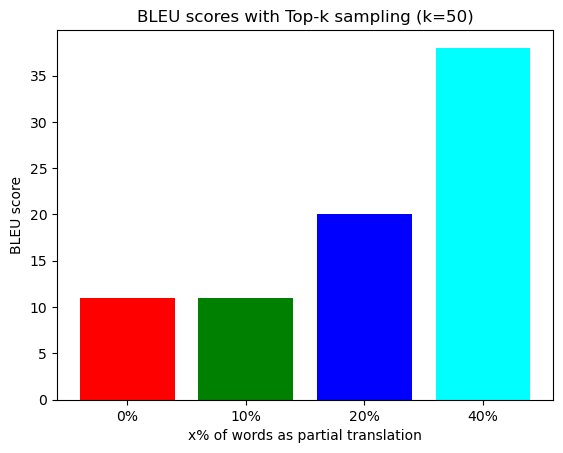

In [45]:
# create a dataset
bars = ('0%', '10%', '20%', '40%')
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.bar(x_pos, topk_sampling_scores, color=['red', 'green', 'blue', 'cyan'])

# Create names on the x-axis
plt.xticks(x_pos, bars)

plt.xlabel('x% of words as partial translation')
plt.ylabel('BLEU score')
plt.title("BLEU scores with Top-k sampling (k=50)")

# Show graph
plt.show()

In [31]:
predictions, top_k_bleu_scores_test = evaluate_on_test_set()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2007/2007 [06:46<00:00,  4.93it/s]


BLEU score with 0.0% partial translation:  0.08687682278200291


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2007/2007 [06:49<00:00,  4.91it/s]


BLEU score with 10.0% partial translation:  0.12240041817541598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2007/2007 [06:49<00:00,  4.90it/s]


BLEU score with 20.0% partial translation:  0.21977127076873804


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2007/2007 [06:43<00:00,  4.97it/s]

BLEU score with 40.0% partial translation:  0.4138182693358924


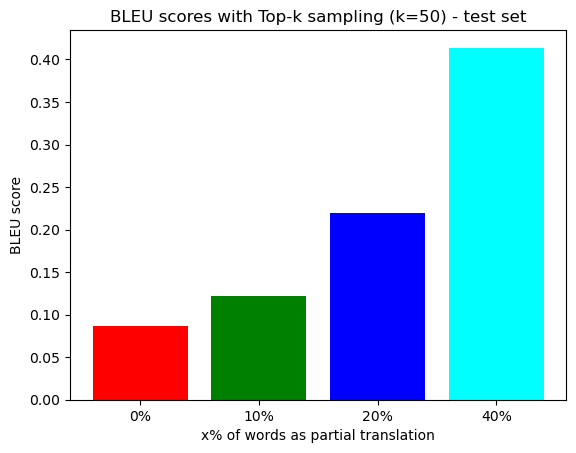

In [32]:
# create a dataset
bars = ('0%', '10%', '20%', '40%')
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.bar(x_pos, top_k_bleu_scores_test, color=['red', 'green', 'blue', 'cyan'])

# Create names on the x-axis
plt.xticks(x_pos, bars)

plt.xlabel('x% of words as partial translation')
plt.ylabel('BLEU score')
plt.title("BLEU scores with Top-k sampling (k=50) - test set")

# Show graph
plt.show()

#### Experiment 4: nucleus sampling

In [33]:
def generate_translation(source_text, words, target_prefix="", max_length=50, num_suggestions=1):
    # Tokenize the source sentence and add special tokens
    input_ids = tokenizer_french.encode(source_text, return_tensors='pt')
    target_ids = tokenizer_eng.encode(target_prefix, return_tensors='pt')

    input_ids = torch.cat((input_ids, target_ids), dim=-1).to(device)

    # Experiment 4: 
    # nucleus sampling
    output = model.generate(
        input_ids, 
        do_sample=True, 
        max_length=50, 
        top_p=0.92, 
        top_k=0
    )
    
    # Decode the generated sequences and remove special tokens
    suggestions = []
    word_suggestions = []
    for i in range(output.shape[0]):
        suggestion = tokenizer.decode(output[i], skip_special_tokens=True)
#         print(suggestion.split())
        suggestion = suggestion[len(target_prefix):].strip()
        suggestions.append(suggestion)
    return suggestions

In [47]:
# debug
source_text = "merci beaucoup pour cet éclaircissement , monsieur le commissaire"
target_prefix = "than"
generate_translation(source_text, 0, target_prefix)

['k you very much, commissioner.']

In [48]:
percent = [0.0, 0.1, 0.2, 0.4]
nucleus_sampling_scores = run_eval(percent)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [06:36<00:00,  5.05it/s]


Dev BLEU score with 0.0% partial translation:  0.11990266435604813


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [06:41<00:00,  4.98it/s]


Dev BLEU score with 10.0% partial translation:  0.12566208867828282


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [06:39<00:00,  5.00it/s]


Dev BLEU score with 20.0% partial translation:  0.20666815270664768


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [06:43<00:00,  4.96it/s]


Dev BLEU score with 40.0% partial translation:  0.38254461376323623


In [50]:
bleu_scores = [0.11990266435604813, 0.12566208867828282, 0.20666815270664768, 0.38254461376323623]
nucleus_sampling_scores = round_scores(bleu_scores)

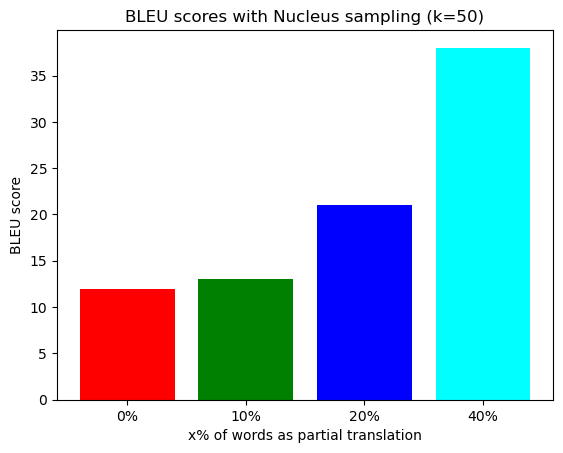

In [51]:
# create a dataset
bars = ('0%', '10%', '20%', '40%')
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.bar(x_pos, nucleus_sampling_scores, color=['red', 'green', 'blue', 'cyan'])

# Create names on the x-axis
plt.xticks(x_pos, bars)

plt.xlabel('x% of words as partial translation')
plt.ylabel('BLEU score')
plt.title("BLEU scores with Nucleus sampling (k=50)")

# Show graph
plt.show()

In [34]:
predictions, top_p_bleu_scores_test = evaluate_on_test_set()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2007/2007 [06:39<00:00,  5.03it/s]


BLEU score with 0.0% partial translation:  0.09680314061153206


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2007/2007 [06:46<00:00,  4.93it/s]


BLEU score with 10.0% partial translation:  0.13118248583550637


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2007/2007 [06:52<00:00,  4.87it/s]


BLEU score with 20.0% partial translation:  0.2295448272752645


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2007/2007 [06:47<00:00,  4.93it/s]

BLEU score with 40.0% partial translation:  0.4202903523817187


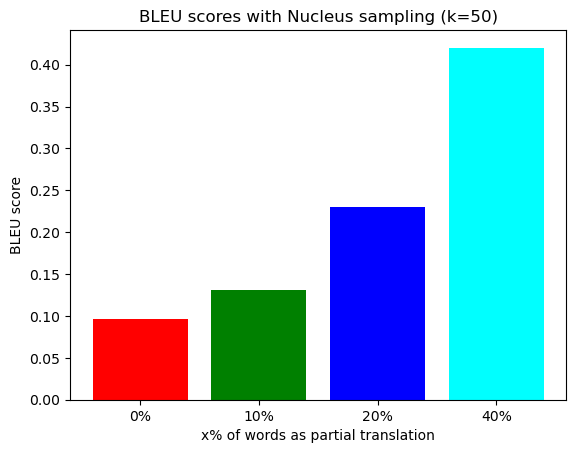

In [35]:
# create a dataset
bars = ('0%', '10%', '20%', '40%')
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.bar(x_pos, top_p_bleu_scores_test, color=['red', 'green', 'blue', 'cyan'])

# Create names on the x-axis
plt.xticks(x_pos, bars)

plt.xlabel('x% of words as partial translation')
plt.ylabel('BLEU score')
plt.title("BLEU scores with Nucleus sampling")

# Show graph
plt.show()

In [13]:
def generate_translation(source_text, words, target_prefix="", max_length=50, num_suggestions=1):
    # Tokenize the source sentence and add special tokens
    input_ids = tokenizer_french.encode(source_text, return_tensors='pt')
    target_ids = tokenizer_eng.encode(target_prefix, return_tensors='pt')

    input_ids = torch.cat((input_ids, target_ids), dim=-1).to(device)

    # Experiment 5: 
    # multiple
    output = model.generate(
        input_ids=input_ids,
        do_sample=True,
        max_length=max_length,
        top_k=50,
        top_p=0.95,
        num_return_sequences=num_suggestions
    )
    
    # Decode the generated sequences and remove special tokens
    suggestions = []
    word_suggestions = []
    for i in range(output.shape[0]):
        suggestion = tokenizer.decode(output[i], skip_special_tokens=True)
#         print(suggestion.split())
        suggestion = suggestion[len(target_prefix):].strip()
        suggestions.append(suggestion)
    return suggestions

In [17]:
percent = [0.0, 0.1, 0.2, 0.4]
topk_topp_scores = run_eval(percent)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [06:32<00:00,  5.10it/s]


Dev BLEU score with 0.0% partial translation:  0.12107021747040947


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [06:34<00:00,  5.07it/s]


Dev BLEU score with 10.0% partial translation:  0.12718631389786647


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [06:35<00:00,  5.06it/s]


Dev BLEU score with 20.0% partial translation:  0.2064257968238083


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [06:42<00:00,  4.97it/s]


Dev BLEU score with 40.0% partial translation:  0.3825580736125818


In [18]:
bleu_scores = [0.12107021747040947, 0.12718631389786647, 0.2064257968238083, 0.3825580736125818]
topk_topp_sampling_scores = round_scores(bleu_scores)

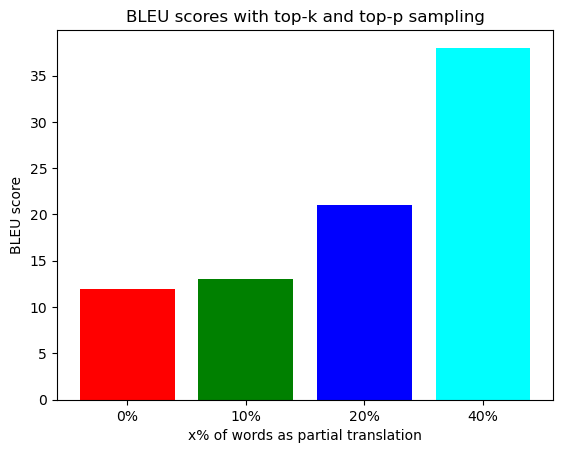

In [22]:
# create a dataset
bars = ('0%', '10%', '20%', '40%')
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.bar(x_pos, topk_topp_sampling_scores, color=['red', 'green', 'blue', 'cyan'])

# Create names on the x-axis
plt.xticks(x_pos, bars)

plt.xlabel('x% of words as partial translation')
plt.ylabel('BLEU score')
plt.title("BLEU scores with top-k and top-p sampling")

# Show graph
plt.show()

In [19]:
percent_0_translations = [0.1937981210087743, 0.09487372037855815, 0.11068094739550842,
                         0.11990266435604813, 0.1210702174704094]
percent_0_translations_rounded = round_scores(percent_0_translations)

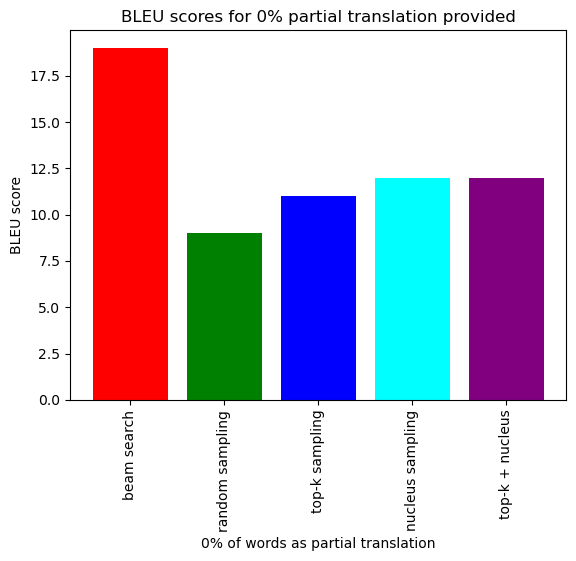

In [30]:
# plot each sampling technique against the percentage
bars = ('beam search', 'random sampling', 'top-k sampling', 'nucleus sampling', 'top-k + nucleus')
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.bar(x_pos, percent_0_translations_rounded, color=['red', 'green', 'blue', 'cyan', 'purple'])

# Create names on the x-axis
plt.xticks(x_pos, bars, rotation='vertical')

plt.xlabel('0% of words as partial translation')
plt.ylabel('BLEU score')
plt.title("BLEU scores for 0% partial translation provided")

# Show graph
plt.show()

In [22]:
percent_10_translations = [0.18211390289638116, 0.10737419352938729, 0.11363497131692624,
                         0.12566208867828282, 0.12718631389786647]
percent_10_translations_rounded = round_scores(percent_10_translations)

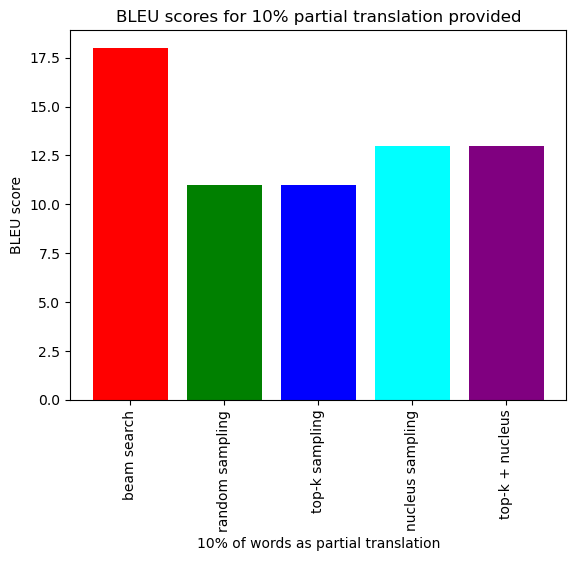

In [31]:
# plot each sampling technique against the percentage
bars = ('beam search', 'random sampling', 'top-k sampling', 'nucleus sampling', 'top-k + nucleus')
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.bar(x_pos, percent_10_translations_rounded, color=['red', 'green', 'blue', 'cyan', 'purple'])

# Create names on the x-axis
plt.xticks(x_pos, bars, rotation='vertical')

plt.xlabel('10% of words as partial translation')
plt.ylabel('BLEU score')
plt.title("BLEU scores for 10% partial translation provided")

# Show graph
plt.show()

In [26]:
percent_20_translations = [0.24911361844302432, 0.18728035455535916, 0.19757166017977995,
                         0.20666815270664768, 0.2064257968238083]
percent_20_translations_rounded = round_scores(percent_20_translations)

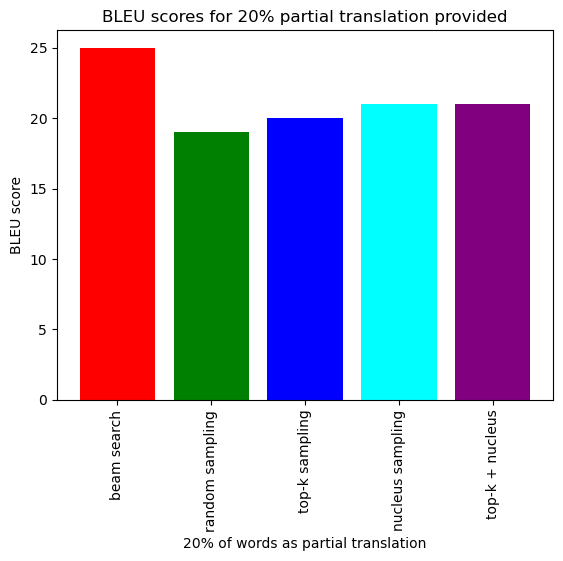

In [32]:
# plot each sampling technique against the percentage
bars = ('beam search', 'random sampling', 'top-k sampling', 'nucleus sampling', 'top-k + nucleus')
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.bar(x_pos, percent_20_translations_rounded, color=['red', 'green', 'blue', 'cyan', 'purple'])

# Create names on the x-axis
plt.xticks(x_pos, bars, rotation='vertical')

plt.xlabel('20% of words as partial translation')
plt.ylabel('BLEU score')
plt.title("BLEU scores for 20% partial translation provided")

# Show graph
plt.show()

In [28]:
percent_40_translations = [0.4104128729595627, 0.3743397749400694, 0.3772971092010412,
                         0.38254461376323623, 0.3825580736125818]
percent_40_translations_rounded = round_scores(percent_40_translations)

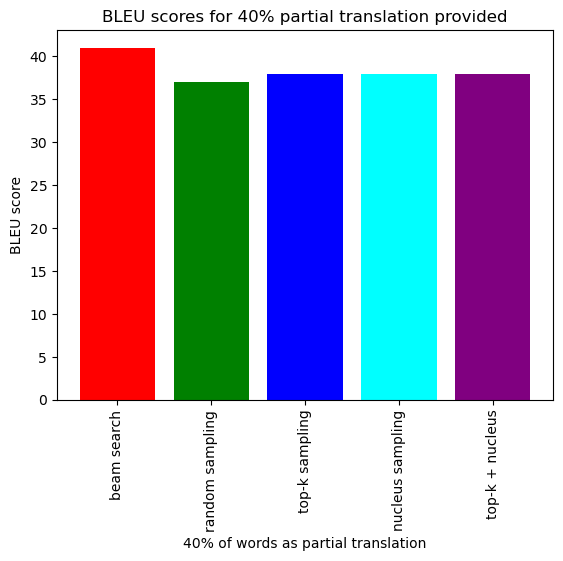

In [33]:
# plot each sampling technique against the percentage
bars = ('beam search', 'random sampling', 'top-k sampling', 'nucleus sampling', 'top-k + nucleus')
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.bar(x_pos, percent_40_translations_rounded, color=['red', 'green', 'blue', 'cyan', 'purple'])

# Create names on the x-axis
plt.xticks(x_pos, bars, rotation='vertical')

plt.xlabel('40% of words as partial translation')
plt.ylabel('BLEU score')
plt.title("BLEU scores for 40% partial translation provided")

# Show graph
plt.show()